In [19]:
import numpy as np  
import os 
from matplotlib import pyplot as plt 
import math

currentDir = os.getcwd()
firstPath = os.path.join(currentDir,"dataFirstMethod.txt")
secondPath = os.path.join(currentDir,'dataSecondMethod.txt')

In [20]:
def convertNumbersRA(inputString):
    prescalers = [15,15/60,15/3600] # Make them degrees, arcminutes,arcseconds
    finalDegree = 0
    for time, number in zip(inputString,prescalers):
        finalDegree += float(time)*number
    return finalDegree

def convertNumbersDELTA(inputString):
    prescalers = [1,1/60,1/3600] # Make them degrees, arcminutes,arcseconds
    finalDegree = 0
    for time, number in zip(inputString,prescalers):
        finalDegree += float(time)*number
    return finalDegree

In [21]:
firstMethodData = {"NAME":[],"RA":[],"DELTA":[]}
secondMethodData = {
    'PARALLAX' : [],
    'PARALLAX_ERROR' : [],
    'VELOCITY' : [],
    'VELOCITY_ERROR' : [],
    'MU_A_COS(DELTA)' : [],
    'MU_A_COS(DELTA)_ERROR' : [],
    'MU_DELTA' : [],
    'MU_DELTA_ERROR' : []
}
keysArray = ['PARALLAX',
    'PARALLAX_ERROR',
    'VELOCITY',
    'VELOCITY_ERROR', 
    'MU_A_COS(DELTA)',
    'MU_A_COS(DELTA)_ERROR',
    'MU_DELTA' ,
    'MU_DELTA_ERROR']

with open(firstPath, 'r') as file:
    line = file.readline()
    while line:
        currentLine = line.strip("\n").split(" ")
        RAString, DELTAString = currentLine[1:4] , currentLine[4:7] #Make all the angles into degrees
        firstMethodData["NAME"].append(currentLine[0])
        firstMethodData["RA"].append(convertNumbersRA(RAString))
        firstMethodData["DELTA"].append(convertNumbersDELTA(DELTAString))
        line = file.readline()
        
with open(secondPath, 'r') as file:
    for line in file:
        currentLine = line.strip("\n").split(" ")[1::] #Clear the line by ignoring the first elements that correspond to the name
        #print(currentLine)
        for index, value in enumerate(currentLine):
            trueValue,trueError = value.split('Â±')
            keyIdValue,keyIdError = keysArray[index*2],keysArray[index*2+1]
            #print(value,trueValue, trueError)
            secondMethodData[keyIdValue].append(float(trueValue))
            secondMethodData[keyIdError].append(float(trueError))
            
for keyToPop in keysArray[2::]:
    firstMethodData[keyToPop] = secondMethodData.pop(keyToPop)
secondMethodData['NAME'] = firstMethodData['NAME']


In [22]:
#The formula for finding the difference between a star (alpha,delta) and the convergent point(alpha_conv,delta_conv) is:
#cos(theta) = sin(delta)*sin(delta_c)+cos(delta)*cos(delta_c)*cos(alpha-alpha_conv)
def findAngleTheta(alpha,delta): #Takes as arguments the RA and DELTA values of the dict row and returns the assigned THETA angle in degrees
    alpha_conv,delta_conv = 96.6, 5.8
    degreeToRadians = math.pi/180
    part1 = math.sin(delta*degreeToRadians)*math.sin(delta_conv*degreeToRadians)
    part2 = math.cos(delta*degreeToRadians)*math.cos(delta_conv*degreeToRadians)*math.cos((alpha-alpha_conv)*degreeToRadians)
    return math.acos(part1 + part2)/degreeToRadians

def addThetaAngleColumn(dictionary): #Takes the dictionary of data and returns the array of all the THETA angles in degrees
    if 'THETA' in dictionary:
        return dictionary['THETA']
    deltaArray,alphaArray = dictionary['DELTA'],dictionary['RA']
    thetaArray = []
    for alpha,delta in zip(alphaArray,deltaArray):
        thetaArray.append(findAngleTheta(alpha,delta))
    return thetaArray

def addTheMuColumn(dictionary):
    if 'MU' in dictionary:
        return dictionary['MU']
    MU_DELTA, MU_A_COS = dictionary['MU_DELTA'], dictionary['MU_A_COS(DELTA)']
    MuArray = []
    for muDelta,muA in zip(MU_DELTA,MU_A_COS):
        MuArray.append(math.sqrt(muDelta**2 + muA**2))
    return MuArray   

def addTheDistanceColumn(dictionary):
    if 'DISTANCE' in dictionary:
        return dictionary['DISTANCE']
    thetaArray,muArray,velocityArray = dictionary['THETA'], dictionary['MU'], dictionary['VELOCITY']
    degreeToRadians = math.pi/180
    distanceArray = []
    for theta,mu,velocity in zip(thetaArray,muArray,velocityArray):
        distanceArray.append(1000*velocity*math.tan(theta*degreeToRadians)/(4.74*mu))
    return distanceArray

def addTheErrorColumn(dictionary):
    if 'ERROR_DISTANCE' in dictionary:
        return dictionary['ERROR_DISTANCE']
    xArray,errorxArray,yArray,erroryArray,muArray = dictionary['MU_A_COS(DELTA)'],dictionary['MU_A_COS(DELTA)_ERROR'],dictionary['MU_DELTA'],dictionary['MU_DELTA_ERROR'],dictionary['MU']
    muErrorArray,distanceErrorArray = [], []
    #Finding the mu error
    for x,errx,y,erry,mu in zip(xArray,errorxArray,yArray,erroryArray,muArray):
        muErrorArray.append(math.sqrt((x*errx)**2+(y*erry)**2)/mu)
    velArray,distanceArray,velocityErrorArray = dictionary['VELOCITY'], dictionary['DISTANCE'],dictionary['VELOCITY_ERROR']
    #Total error for second error
    for vel,velerr,mu,muerr,r in zip(velArray,velocityErrorArray,muArray,muErrorArray,distanceArray):
        distanceErrorArray.append(r*math.sqrt((velerr/vel)**2+(muerr/mu)**2))
    return distanceErrorArray
    

In [23]:
firstMethodData.update({'THETA': addThetaAngleColumn(firstMethodData)})
firstMethodData.update({'MU': addTheMuColumn(firstMethodData)})
firstMethodData.update({'DISTANCE': addTheDistanceColumn(firstMethodData)})
firstMethodData.update({'DISTANCE_ERROR':addTheErrorColumn(firstMethodData)})

In [24]:
def addSecondMethodDistance(dictionary): 
    if 'DISTANCE' in dictionary:
        return dictionary['DISTANCE']
    distanceArray,parallaxArray = [], dictionary['PARALLAX']
    for par in parallaxArray:
        distanceArray.append(1000/par)
    return distanceArray  

def addSecondMethodDistanceError(dictionary):
    if 'DISTANCE_ERROR' in dictionary:
        return dictionary['DISTANCE_ERROR']
    parallaxArray, parallaxErrorArray,distanceArray = dictionary['PARALLAX'],dictionary['PARALLAX_ERROR'],dictionary['DISTANCE']
    distanceErrorArray = []
    for par,parerror,dis in zip(parallaxArray, parallaxErrorArray,distanceArray):
        distanceErrorArray.append(dis*parerror/par)
    return distanceErrorArray
    

In [25]:
secondMethodData.update({'DISTANCE': addSecondMethodDistance(secondMethodData)})
secondMethodData.update({'DISTANCE_ERROR': addSecondMethodDistanceError(secondMethodData)})

In [26]:
def clearData(dictionaryFirstMethod,dictionarySecondMethod):
    threshold,center = 10 ,46.34
    totalData = {
        'NAME':[],
        'DISTANCE_FIRST':[],
        'DISTANCE_FIRST_ERROR':[],
        'DISTANCE_SECOND':[],
        'DISTANCE_SECOND_ERROR' : []
        }
    distArray1,distArray2 = dictionaryFirstMethod['DISTANCE'],dictionarySecondMethod['DISTANCE']
    for index, (starDist,starDist2) in enumerate(zip(distArray1,distArray2)):
        if (abs(starDist - center) < threshold):# and (abs(starDist2 - center) < threshold): # we will require that by both methods the stars are in the center, as otherwise it will be unwise
            totalData['NAME'].append(dictionaryFirstMethod['NAME'][index])
            totalData['DISTANCE_FIRST'].append(dictionaryFirstMethod['DISTANCE'][index])
            totalData['DISTANCE_FIRST_ERROR'].append(dictionaryFirstMethod['DISTANCE_ERROR'][index])
            totalData['DISTANCE_SECOND'].append(dictionarySecondMethod['DISTANCE'][index])
            totalData['DISTANCE_SECOND_ERROR'].append(dictionarySecondMethod['DISTANCE_ERROR'][index])
    return totalData

def addDifferenceColumn(dictionary):
    if 'DIFFERENCE' in dictionary:
        return dictionary
    differenceArray, diffErrorArray = [], []
    dis1Array,dis2Array, err1Array, err2Array = dictionary['DISTANCE_FIRST'],dictionary['DISTANCE_SECOND'],dictionary['DISTANCE_FIRST_ERROR'],dictionary['DISTANCE_SECOND_ERROR']
    for dis1,dis2,err1,err2 in zip(dis1Array,dis2Array, err1Array, err2Array):
        differenceArray.append(dis1-dis2)
        diffErrorArray.append(np.sqrt(err1**2+err2**2))
    return {'DIFFERENCE': differenceArray,'DIFFERENCE_ERROR': diffErrorArray}

def calculateAverage(valueArray,valueErrorArray,name):
    valueAverage, valueErrorAverage, size = 0, 0, len(valueArray)
    for val,err in zip(valueArray,valueErrorArray):
        valueAverage += val 
        valueErrorAverage += err
    print(f'The mean distance to the cluster using the '+ name +f" method is {valueAverage/size} ± {valueErrorAverage/size} pc")
    pass
    # return valueAverage/size, valueErrorAverage/size

In [27]:
totalData = clearData(firstMethodData,secondMethodData)
totalData.update(addDifferenceColumn(totalData))

In [28]:
calculateAverage(totalData["DISTANCE_FIRST"],totalData['DISTANCE_FIRST_ERROR'],'first')
calculateAverage(totalData["DISTANCE_SECOND"],totalData['DISTANCE_SECOND_ERROR'],'second')

The mean distance to the cluster using the first method is 44.600124956398105 ± 1.774697362592901 pc
The mean distance to the cluster using the second method is 48.89909452419951 ± 2.2420412732483843 pc


In [29]:
meanDifference,errorDifference = 0, 0
for value,error in zip(totalData['DIFFERENCE'],totalData['DIFFERENCE_ERROR']):
    meanDifference += abs(value)
    errorDifference += error**2
    #print(value, error)
meanDifference = meanDifference #/ len(totalData['DIFFERENCE'])
errorDifference = math.sqrt(errorDifference) #/ len(totalData['DIFFERENCE'])
print(f'The mean difference for the both methods {meanDifference} with an error of {errorDifference}')
print(f'That value excludes the zero value at a {abs(meanDifference/errorDifference)} sigma confidence level')

The mean difference for the both methods 144.95831998363877 with an error of 18.532429451985564
That value excludes the zero value at a 7.82187356272968 sigma confidence level


In [30]:
RaArray, DeltaArray = [] , []
distance,distanceError = totalData['DISTANCE_FIRST'],totalData['DISTANCE_FIRST_ERROR']

for index, element1 in enumerate(firstMethodData['NAME']):
    for element in totalData['NAME']:
        if element1 == element:
            RaArray.append(firstMethodData['RA'][index])
            DeltaArray.append(firstMethodData['DELTA'][index])
            break 

In [31]:
def plot_points_and_circles(x, y, dis,error):
    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')
    
    for i in range(len(x)):
        ax.plot(x[i], y[i]) 
        circle = plt.Circle((x[i], y[i]), dis[i]/100, color='white', fill=True)  #add the circles with the error bars
        errorCircle = plt.Circle((x[i],y[i]),dis[i]/75 + error[i]/5,color='r',fill=False)
        ax.add_artist(circle) 
        ax.add_artist(errorCircle)

    plt.xlabel('Right Ascension(degrees)')
    plt.xlim(40,90)
    plt.ylim(0,30)
    ax.invert_xaxis() #For convention, as Ra goes right to left
    plt.ylabel('Delta(degrees)')
    plt.title('The Hyades in the sky')
    plt.grid(True)
    plt.savefig('HyadesNight')
    plt.show()

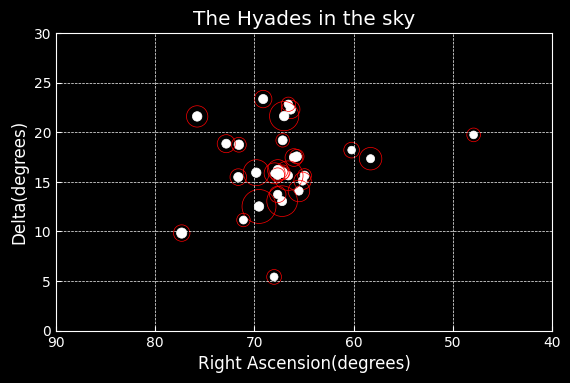

In [32]:
plt.style.use("dark_background")
plot_points_and_circles(RaArray,DeltaArray,distance,distanceError)

In [33]:
points = np.linspace(40,54,500)
plt.rcdefaults()
plt.style.use('bmh')
def gaussian(x,median,deviation):
    return np.exp(-(x-median)**2/(2*deviation**2))*(1/(deviation*np.sqrt(2*math.pi)))

In [34]:
clusterMedian = 44.600124956398105
clusterDeviation = 1.774697362592901
parallaxMedian = 48.89909452419951
parallaxDeviation = 2.2420412732483843

In [35]:
parallaxExp = gaussian(points,parallaxMedian,parallaxDeviation)
clusterExp  = gaussian(points,clusterMedian, clusterDeviation ) 
trueValueExp = gaussian(points,46.34,0.27)#47.03,0.20) #https://www.aanda.org/articles/aa/full_html/2019/03/aa34045-18/aa34045-18.html
# parallaxExpStrict = gaussian(points,47.02007207663225 , 2.0167075725224954)
# clusterExpStrict  = gaussian(points,44.45568396271792 , 1.8275206846673697 )

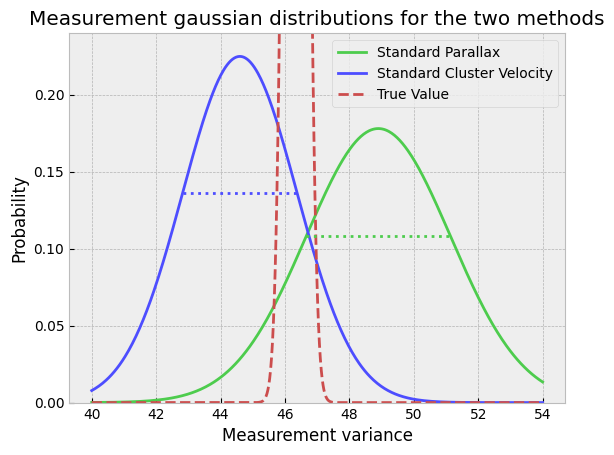

In [36]:

plt.plot(points,parallaxExp, label='Standard Parallax',color=(0.30,0.80,0.3))
plt.plot(points,clusterExp, label='Standard Cluster Velocity',color=(0.30,0.30,1))
# plt.plot(points,parallaxExpStrict, label='Standard Parallax Strict')
# plt.plot(points,clusterExpStrict, label='Standard Cluster Velocity Strict')
plt.plot(points,trueValueExp,linestyle = '--',label='True Value',color=(0.8,0.3,0.3))

parallaxYatSigma = gaussian(parallaxMedian + parallaxDeviation, parallaxMedian, parallaxDeviation)
clusterYatSigma = gaussian(clusterMedian + clusterDeviation, clusterMedian, clusterDeviation)

# Add horizontal bars at one standard deviation
plt.hlines(y=parallaxYatSigma, xmin=parallaxMedian - parallaxDeviation, xmax=parallaxMedian + parallaxDeviation, colors=(0.30, 0.80, 0.3), linestyles='dotted')
plt.hlines(y=clusterYatSigma, xmin=clusterMedian - clusterDeviation, xmax=clusterMedian + clusterDeviation, colors=(0.30, 0.30, 1), linestyles='dotted')
plt.title('Measurement gaussian distributions for the two methods')
plt.ylim(0,0.24)
plt.xlabel('Measurement variance')
plt.ylabel('Probability')
plt.savefig('Gaussians')
plt.legend()

In [41]:
def saveDictionary(dict,filename):
    with open(filename, 'w') as file:
        header = '\t'.join(dict.keys())
        file.write(header + "\n")
        maxLength = max(len(arr) for arr in dict.values()) #Find the max iteration
        for index in range(maxLength):
            row = []
            for key in dict.keys(): #Get the current key
                if index < len(dict[key]): #If the value I want is withing the max range then appended it to the row
                    row.append(str(dict[key][index]))
                else:
                    row.append('') #Else append nothing
            file.write('\t'.join(row) + '\n') #Print the whole row
    pass 

In [44]:
saveDictionary(firstMethodData,'firstMethodDataAnalysisFinal.txt')
saveDictionary(secondMethodData,'secondMethodDataAnalysisFinal.txt')
saveDictionary(totalData,'totalDataAnalysisFinal.txt')